In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import pyfiles.lib as lib
import pyfiles.models as models

In [2]:
num_noise = batch_size = 100
num_hidden = 256

In [3]:
# standardization code
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), ])

# MNIST dataset
train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_data  = torchvision.datasets.MNIST(root='data/', train=False, transform=transform, download=True)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

(3, 62, 242)


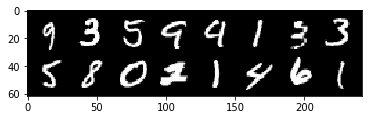

In [4]:
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
lib.imshow_grid(example_mini_batch_img[0:16,:,:])

[Epoch 1/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 2/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 3/200]Real Image Probability: 8.999, Generated Image Probability: -0.000
[Epoch 4/200]Real Image Probability: 8.959, Generated Image Probability: -0.000
[Epoch 5/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 6/200]Real Image Probability: 8.980, Generated Image Probability: -0.000
[Epoch 7/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 8/200]Real Image Probability: 319.652, Generated Image Probability: -0.000
[Epoch 9/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 10/200]Real Image Probability: 1655.183, Generated Image Probability: -0.000
(3, 92, 242)


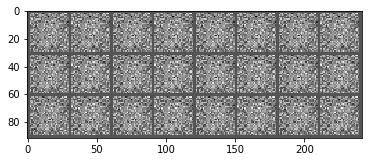

[Epoch 11/200]Real Image Probability: 132.308, Generated Image Probability: -0.000
[Epoch 12/200]Real Image Probability: 6.827, Generated Image Probability: -0.000
[Epoch 13/200]Real Image Probability: 4297.501, Generated Image Probability: -0.000
[Epoch 14/200]Real Image Probability: 0.717, Generated Image Probability: -0.000
[Epoch 15/200]Real Image Probability: 4053.564, Generated Image Probability: -0.000
[Epoch 16/200]Real Image Probability: 8.975, Generated Image Probability: -0.000
[Epoch 17/200]Real Image Probability: 8.934, Generated Image Probability: -0.000
[Epoch 18/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 19/200]Real Image Probability: 5261.403, Generated Image Probability: -0.000
[Epoch 20/200]Real Image Probability: 4950.811, Generated Image Probability: -0.000
(3, 92, 242)


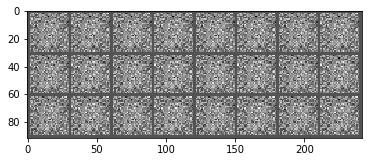

[Epoch 21/200]Real Image Probability: 8.991, Generated Image Probability: -0.000
[Epoch 22/200]Real Image Probability: 1056.026, Generated Image Probability: -0.000
[Epoch 23/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 24/200]Real Image Probability: 607.357, Generated Image Probability: -0.000
[Epoch 25/200]Real Image Probability: 8.988, Generated Image Probability: -0.000
[Epoch 26/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 27/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 28/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 29/200]Real Image Probability: 8.986, Generated Image Probability: -0.000
[Epoch 30/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
(3, 92, 242)


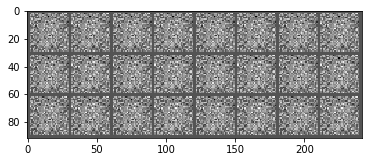

[Epoch 31/200]Real Image Probability: 1518.122, Generated Image Probability: -0.000
[Epoch 32/200]Real Image Probability: 9.000, Generated Image Probability: -0.000
[Epoch 33/200]Real Image Probability: 5684.042, Generated Image Probability: -0.000
[Epoch 34/200]Real Image Probability: 1369.367, Generated Image Probability: -0.000
[Epoch 35/200]Real Image Probability: 8.758, Generated Image Probability: -0.000
[Epoch 36/200]Real Image Probability: 8.998, Generated Image Probability: -0.000
[Epoch 37/200]Real Image Probability: 9.000, Generated Image Probability: -0.000


KeyboardInterrupt: 

In [11]:
epochs = 200
ld = 10
gen = models.Generator_FC(input_node_size=num_noise)
disc = models.Discriminator_FC()
bceloss = torch.nn.BCELoss()

if torch.cuda.is_available():
    gen = gen.cuda()
    disc = disc.cuda()
    bceloss = bceloss.cuda()

lib.init_params(gen)
lib.init_params(disc)

gen_optim = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0, 0.9))
disc_optim = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0, 0.9))

for epoch in range(epochs):
    running_loss = 0.0
    disc.train()
    gen.train()
    
    for i, data in enumerate(train_data_loader):
        x, _ = data
        num_data = x.shape[0]
        noise = lib.sample_noise(num_data, num_noise)
        
        ones = torch.ones((num_data, 1), requires_grad=False)
        zeros = torch.zeros((num_data, 1), requires_grad=False)
        
        if torch.cuda.is_available():
            x = x.cuda()
            noise = noise.cuda()
            ones = ones.cuda()
            zeros = zeros.cuda()
        
        _x = x.view(-1, 28*28)
        gen_img = gen(noise).view(num_data, -1)
                      
        ## Regularization Term
        eps = torch.rand(1).item()
        x_hat = _x.detach().clone() * eps + gen_img.detach().clone() * (1 - eps)
        x_hat.requires_grad = True
        
        grad_x = disc(x_hat).sum()
        grad_x.backward()
        
        reg = ld * ((x_hat.grad ** 2).sum().sqrt() - 1) ** 2
        
        ### Discriminator
        disc_optim.zero_grad()
        p_real = disc(_x)
        p_fake = disc(gen_img.detach())
        
        loss_d = torch.mean(reg - p_real + p_fake)
        loss_d.backward()
        disc_optim.step()
        
        if i % 5 == 0:
            ### Generator
            gen_optim.zero_grad()
            p_fake = disc(gen_img.view(-1, 28*28))

            loss_g = -torch.mean(p_fake)
            loss_g.backward()
            gen_optim.step()

    print("[Epoch %d/%d] D loss: %.3f, G loss: %.3f" % (epoch+1, epochs, loss_d.item(), loss_g.item()))

    if epoch % 10 == 9:
        disc.eval()
        gen.eval()
        
        p_real = p_gen = 0.0
        noise = lib.sample_noise(24, num_noise)
        if torch.cuda.is_available():
            noise = noise.cuda()
            
        fake_img = gen(noise).view((-1, 1, 28, 28))
        lib.imshow_grid(fake_img)
        #lib.imsave(fake_img, epoch)